In [ ]:
#@title Mount Google Drive and set output for models directory {"display-mode": "form"}

import os
from google.colab import drive
drive.mount('/gdrive')
# OUTDIR will be used to save data, it must already exist
OUTDIR = "/gdrive/MyDrive/university/unibo/nlp/assignment1" #@param

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Dataset
Download data and save it locally on `./dataset`

## Data load

In [ ]:
import os
import urllib.request
from zipfile import ZipFile

# create directory if needed
dataset_folder = os.path.join(os.getcwd(), "dataset", "original")
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

# download dataset
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
dataset_path = os.path.join(dataset_folder, "Treebank.zip")
if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)

# extract zip file
zip = ZipFile(dataset_path)
zip.extractall(dataset_folder)
zip.close()

## Dataframe load

We load train, validation and testing files in different structures so that we can handle them separately. 

In [ ]:
import re

files_folder = os.path.join(os.path.join(dataset_folder, "dependency_treebank"))
filenames = os.listdir(files_folder)

train_files = list()
valid_files = list()
test_files = list()

for filename in filenames:
  file_id = int(re.findall("\d+", filename)[0])
  filepath = os.path.join(files_folder, filename) 

  if file_id < 101:
    train_files.append(filepath)
  elif file_id < 151:
    valid_files.append(filepath)
  else:
    test_files.append(filepath)

We are going to store our data in structure in a list where each element will represent a sentence, independently if we split by sentences or not. This is beacuse we can interpret the whole document as a sentence if we wish to do so. 

Each sentence will be composed of several tuples containing the token (i.e. the word we want to predict the role) and the label.

For instance, if we split the file `wsj_0001.dp` by sentence, we might end up with something like
```
[
  [("Pierre", "NNP"), ("Vinken", "NNP"), (",", ",") ...],
  [("Mr.", "NNP"), ("Vinken, "NNP") ...]
]
```

While loading data we will also perform the **preprocessing** step in order to avoid doing it later and save computational effort.
Based on the [English Penn Treebank tagset](https://www.sketchengine.eu/penn-treebank-tagset/) we perform the following preprocessing steps on the text corpus:

* Lowercase everything
* Unify all brackets `[,{,(` into `(` and `],},)` into `)`
* Unify punctuation `;:` into `:`
* Strip text out of `\n`, `\t`... (python `strip` function)

Given the above tagset we will also perform preprocessing on the data labels, in particular we will remove every symbol from label except for `$` after a word.

In [ ]:
import re
from functools import reduce

OPEN_PARENTHESIS_RE = re.compile('[\[({]')
CLOSED_PARENTHESIS_RE = re.compile('[\])}]')
PUNCTUATION_RE = re.compile('[;:]')
WORD_RE = re.compile('\w+\$?')

PREPROCESSING_PIPELINE = [
  lambda t: t.lower(), # lower all the text
  lambda t: OPEN_PARENTHESIS_RE.sub('(', t), # replace open parenthesis
  lambda t: CLOSED_PARENTHESIS_RE.sub(')', t), # replace closed parenthesis
  lambda t: PUNCTUATION_RE.sub(':', t), # replace closed parenthesis
  lambda t: t.strip() # strip text
]

preprocess_text = lambda input: reduce(lambda txt, f: f(txt), PREPROCESSING_PIPELINE, input)
preprocess_label = lambda input: WORD_RE.findall(input)[0] if len(WORD_RE.findall(input)) > 0 else input

In [ ]:
from tqdm.notebook import tqdm
from natsort import natsorted

def load_files(files, split_by_sentence=True):
  # if we wish to split by sentences we can do so by splitting over two
  # consecutives newlines, otherwise we can just use the whole document as it is
  get_sentences = lambda x: x.split("\n\n") if split_by_sentence else lambda x: [x]

  m = list()
  for f in tqdm(natsorted(files)):
    try:
      with open(f, mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        sentences = get_sentences(text)

        for sentence in sentences:
          mrow = list()
          for line in sentence.split("\n"):
            if len(line.strip()) > 0:
              # extract each word and token from the file
              word, token, _ = line.split("\t")
              mrow.append((preprocess_text(word), preprocess_label(token.strip())))
          m.append(mrow)
    except Exception as e:
        print(f"Error while reading file {f}: {e}")

  return m

In [ ]:
#@title Load data from files {"display-mode": "form"}

split_by_sentence = True#@param {type:"boolean"}

train_data = load_files(train_files, split_by_sentence=split_by_sentence)
valid_data = load_files(valid_files, split_by_sentence=split_by_sentence)
test_data = load_files(test_files, split_by_sentence=split_by_sentence)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

# Embeddings computation

Word embeddings are computed using GloVe embeddings.

## Download embeddings

In [ ]:
#@title Specify the embedding dimension of the GloVe vector embeddings { display-mode: "form" }
import gensim
import gensim.downloader as gloader

EMBEDDING_DIMENSION = 50 #@param [50, 100, 200, 300]
download_path = f"glove-wiki-gigaword-{EMBEDDING_DIMENSION}"
embedding_model = gloader.load(download_path)

[==================================================] 100.0% 66.0/66.0MB downloaded


Downloaded GloVe embeddings are trained on an english dump of Wikipedia.
They should contain most of the words used in our dataset, let's take a look into how many terms of our dataset are out of this vocabulary.

In [ ]:
dataset_vocab = set([w for sentence in train_data for w,t in sentence]).union(
                set([w for sentence in valid_data for w,t in sentence]),
                set([w for sentence in test_data for w,t in sentence]))
glove_vocab = set(embedding_model.vocab.keys())
oov_terms = dataset_vocab.difference(glove_vocab)
print(f"{len(oov_terms)} words are out of vocabulary ({(len(oov_terms)/len(dataset_vocab))*100:.2f}%)")
print(f"some of which are {list(oov_terms)[:10]}")

676 words are out of vocabulary (6.18%)
some of which are ['family-planning', 'bumkins', 'four-foot-high', '129.91', 'yeargin', 'sport-utility', 'corn-buying', 'state-supervised', 'test-practice', 'achievement-test']


## Tokenization of words

Tokenization is performed by making use of `keras` function `keras.preprocessing.text.Tokenizer`.

We build a wrapper around it so that we can use our own implementation of out of vocabulary embeddings. 

In [ ]:
from tqdm.notebook import tqdm
import tensorflow as tf
import numpy as np
from itertools import chain

class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """
    def __init__(self,  
                 embedding_model=None,
                 tokenizer_args=None, 
                 debug=False,
                 oov_embed_range=(-0.05, 0.05)):
        self.embedding_dimension = embedding_model.vector_size
        self.embedding_model = embedding_model
        self.debug = debug
        self.oov_embed_range = oov_embed_range

        self.embedding_matrix = None
        self.vocab = None

        self.tokenizer_args = {} if tokenizer_args is None else tokenizer_args

    def build_embedding_matrix(self):
      """
      Builds the embedding matrix
      """
      self.embedding_matrix = np.zeros((len(self.vocab) + 1, self.embedding_dimension), dtype=np.float32)

      for word, idx in tqdm(self.vocab.items()):
        try:
          embedding_vector = self.embedding_model[word]
        except (KeyError, TypeError):
          embedding_vector = np.random.uniform(low=self.oov_embed_range[0], 
                                               high=self.oov_embed_range[1], 
                                               size=self.embedding_dimension)
        self.embedding_matrix[idx] = embedding_vector

    def build_vocab(self, data, **kwargs):
        """
        Build the vocabulary using the keras tokenizer, based on spaces
        """
        # fit the keras tokenizer
        if self.debug: print('Tokenizing using keras... ', end="")
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=[], **self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)

        self.vocab = self.tokenizer.word_index
        self.build_embedding_matrix()
        if self.debug: print('Done')

    def update_vocab(self, new_data):
      """
      Update the vocabulary on new data. If out-of-vocabulary words are met then
      their embedding is computed
      """
      old_vocab = set(self.vocab.keys())

      # update the vocabulary
      if self.debug: print("Tokenizing new data using keras... ", end="")
      self.tokenizer.fit_on_texts(new_data)
      if self.debug: print("Done")
      self.vocab = self.tokenizer.word_index

      new_vocab = set(self.vocab.keys())
      new_words = new_vocab.difference(old_vocab)
      
      for nw in tqdm(new_words):
        try:
          embedding_vector = self.embedding_model[nw]
        except (KeyError, TypeError):
          embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=self.embedding_dimension)

        self.embedding_matrix = np.vstack((self.embedding_matrix, embedding_vector))
      
    @property
    def info(self):
      return {
        'embedding_dimension': self.embedding_dimension,
        'vocab_size': len(self.vocab) + 1,
      }

    def tokenize(self, text):
      return text

    def convert_tokens_to_ids(self, tokens):
      if type(tokens) == str:
        return self.tokenizer.texts_to_sequences([tokens])[0]
      else:
        return list(chain(*self.tokenizer.texts_to_sequences(tokens)))

    def convert_ids_to_tokens(self, ids):
      return self.tokenizer.sequences_to_texts(ids)

We can now build the tokenizer by using `tokenizer = KerasTokenizer(embedding_model, {"oov_token": 1})`, build the vocabulary by using `tokenizer.build_vocab(text)` and update it with new text with `tokenizer.update_vocab(text)`.


In [ ]:
tokenizer = KerasTokenizer(embedding_model, {"oov_token": 1})

## Categorization of labels

We will perform one-hot encoding of labels using `sklearn.preprocessing.OneHotEncoding`.

We will restrict our labels to the one found in the dataset.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
# fit label encoder
label_encoder = LabelBinarizer()
labels = set([t for sentence in train_data for w,t in sentence]).union(
          set([t for sentence in valid_data for w,t in sentence]),
          set([t for sentence in test_data for w,t in sentence]))
label_encoder = label_encoder.fit(list(labels))

# Neural model

## Prepare data

We'll prepare training data by fitting the tokenizer on training data first in order to build the inner vocabulary.
We can then update the tokenizer vocabulary with validation and testing data without worrying about computing again out of vocabulary embeddings.



In [ ]:
# fit tokenizer with train data
tokenizer.build_vocab(set([w for sentence in train_data for w,t in sentence]))
# update tokenizer with validation and testing data
tokenizer.update_vocab(set([w for sentence in valid_data for w,t in sentence]))
tokenizer.update_vocab(set([w for sentence in test_data for w,t in sentence]))

  0%|          | 0/7404 [00:00<?, ?it/s]

  0%|          | 0/2497 [00:00<?, ?it/s]

  0%|          | 0/1046 [00:00<?, ?it/s]

and then split it first into tokenized samples; to do so we compute the maximum sequence length so that we can then pad all shorter strings to the maximum sequence length.

Sequence length is computed **only on training data**.

In [ ]:
# compute maximum sequence length
MAX_SEQ_LENGTH = max([len(s) for s in train_data])
# number of labels
NUM_LABELS = label_encoder.classes_.shape[0]

With each parameter we can now build the training, testing and validation data into a format that can be directly fed into keras training loop.

In [ ]:
def prepare_data(data, max_seq_length=None, num_labels=None):
  # x has one row per samples and one column per token up to max_seq_length,
  # with 0-padding when needed
  x = np.zeros((len(data), max_seq_length))
  # y has the same structure as x but one additional dimension which
  # encodes the role of each token
  y = np.zeros((len(data), max_seq_length, num_labels))

  for idx, sentence in tqdm(enumerate(data)):
    # compute x entry by tokenizing each word in a single array
    tokenized = tokenizer.convert_tokens_to_ids([w for w, _ in sentence])
    # compute the padding required and 0-pad the vector to reach max seq length
    to_pad = max_seq_length - len(tokenized)
    padded = np.pad(tokenized, (0, to_pad))
    x[idx] = padded

    # compute y entry by binarizing each label with one hot encoding method
    onehot_encoded = label_encoder.transform([t for _, t in sentence])
    # pad the array, required pad is still the same as it depends on the sequence length
    padded = np.pad(onehot_encoded, ((0, to_pad), (0, 0)))
    y[idx] = padded

  return x, y

In [ ]:
x_train, y_train = prepare_data(train_data, max_seq_length=MAX_SEQ_LENGTH, num_labels=NUM_LABELS)
x_valid, y_valid = prepare_data(valid_data, max_seq_length=MAX_SEQ_LENGTH, num_labels=NUM_LABELS)
x_test, y_test = prepare_data(test_data, max_seq_length=MAX_SEQ_LENGTH, num_labels=NUM_LABELS)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
from tensorflow.keras.layers import Layer

## Model definition

In [ ]:
#@title Default neural model creation helper
#@markdown We define an helper function, `build_model`, so that we can build
#@markdown models on the fly.
import pickle
from typing import List, Tuple
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Embedding
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.optimizer import Adam

EMBEDDING_LAYER = Embedding(
  output_dim=EMBEDDING_DIMENSION,
  input_dim=tokenizer.info["vocab_size"],
  input_length=MAX_SEQ_LENGTH,
  weights=[tokenizer.embedding_matrix],
  mask_zero=True
)

DEFAULT_LEARNING_RATE = 1e-3 #@param {type: "number"}
#@markdown Minimum improvement on the loss value after each epoch
DEFAULT_MIN_IMPROVEMENT = 1e-2#@param {"type":"number"}
#@markdown Maximum number of times the minimum improvement criterion can be ignored
DEFAULT_IMPROVEMENT_PATIENCE = 5#@param {"type":"number"}
DEFAULT_EPOCHS = 100#@param {"type": "number"}

def build_model(model_name: str,
                x_train: np.array, y_train: np.array,
                x_valid: np.array, y_valid: np.array,
                layers: List[Layer] = [], 
                learning_rate: float = DEFAULT_LEARNING_RATE,
                epochs: int = DEFAULT_EPOCHS,
                min_improvement: float = DEFAULT_MIN_IMPROVEMENT,
                improvement_patience: int = DEFAULT_IMPROVEMENT_PATIENCE, 
                debug: bool = False,
                save: bool = True) -> Tuple[Sequential, History]:
  """
  Build a neural model and train it on the fly.

  Args:
      model_name (str): The model name used to save the model, if specified.
      x_train (np.array): Train samples
      y_train (np.array): Labels of each train sample
      x_valid (np.array): Validation samples
      y_valid (np.array): Labels of each validation sample
      layers (List[Layer], optional): Layers that will follow the sentence embedding layer. Defaults to [].
      learning_rate (float, optional): Defaults to DEFAULT_LEARNING_RATE.
      epochs (int, optional): Defaults to DEFAULT_EPOCHS.
      min_improvement (float, optional): Minimum absolute improvement in validation loss over consecutive epochs. Defaults to DEFAULT_MIN_IMPROVEMENT.
      improvement_patience (int, optional): Maximum number of times improvement constraint can be ignored. Defaults to DEFAULT_IMPROVEMENT_PATIENCE.
      debug (bool, optional): Defaults to False.
      save (bool, optional): Save the model with the specified name in OUTDIR. Defaults to True.
  Returns:
      tuple(Sequential, History): Neural network model
  """
  assert len(layers) > 0, "You need to specify at least 1 layers"

  # build the model using the Sequential API
  model = Sequential()
  model.add(EMBEDDING_LAYER)
  for layer in layers:
    model.add(layer)

  # compile the model so that its runnable
  model.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=learning_rate),
               metrics=["accuracy"])
  
  # setup earlystopping callback so that we can easily avoid overfitting
  earlystopping_cb = EarlyStopping(min_delta=min_improvement, 
                                   patience=improvement_patience)

  # train the model
  train_history = model.fit(x_train, y_train,
            validation_data=(x_valid, y_valid),
            batch_size=MAX_SEQ_LENGTH,
            epochs=epochs,
            callbacks=[earlystopping_cb])
  
  if save:
    model.save(os.path.join(OUTDIR, model_name, "_weights"))
    # save the training history
    with open(os.path.join(OUTDIR, model_name, "_history")) as f:
      pickle.dump(train_history, f)

  return train_history, model

## Baseline model

Baseline uses a bidirectional LSTM network.

In [ ]:
#@title Model training {"display-mode": "form"}
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.models import load_model

def BaselineModel(params):

  lr = params['learning_rate'] if params['learning_rate'] else DEFAULT_LEARNING_RATE
  epochs = params['epochs'] if params['epochse'] else DEFAULT_EPOCHS
  baseline_layers = [Bidirectional(LSTM(MAX_SEQ_LENGTH, return_sequences=True)),
                    TimeDistributed(Dense(NUM_LABELS, activation="softmax"))
  ]

  load_model = False #@param {type: "boolean"}
  if load_model and os.path.exists(os.path.join(OUTDIR, "baseline")):
    baseline_model = load_model(os.path.join(OUTDIR, "baseline"))
  else:
    baseline_model, baseline_train_history = build_model(
        "baseline", x_train, y_train, x_valid, y_valid, layers=baseline_layers,
        learning_rate=lr, #@param
        epochs=epochs, #@param
        min_improvement=DEFAULT_MIN_IMPROVEMENT, #@param,
        improvement_patience=DEFAULT_IMPROVEMENT_PATIENCE, #@param 
        debug=False, #@param {type: "boolean"}
        save=True, #@param {type: "boolean"}
    )

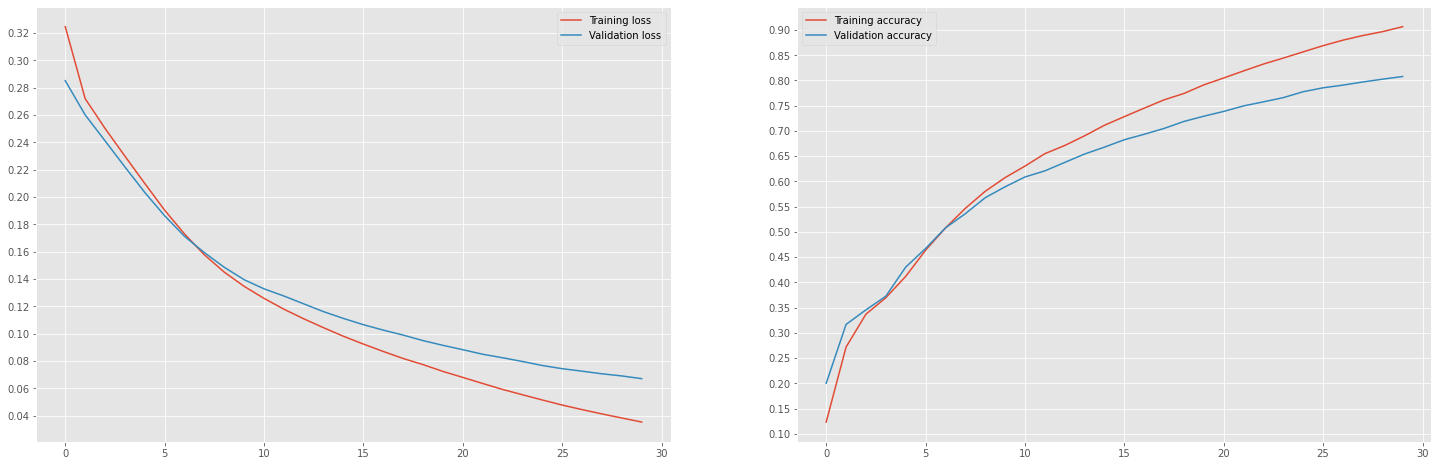

In [ ]:
#@title Plot loss and accuracy 
import matplotlib.pyplot as plt
plt.style.use("ggplot")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))
ax1.plot(baseline_train_history.history["loss"], label="Training loss")
ax1.plot(baseline_train_history.history["val_loss"], label="Validation loss")
ax1.locator_params(axis='y', nbins=20)
ax1.legend()

ax2.plot(baseline_train_history.history["accuracy"], label="Training accuracy")
ax2.plot(baseline_train_history.history["val_accuracy"], label="Validation accuracy")
ax2.locator_params(axis='y', nbins=25)
ax2.legend()

plt.show()

## GRU model

Same as baseline model but with a GRU layer instead of a LSTM layer.

In [ ]:
#@title Model setup {"display-mode": "form"}
from keras.layers import GRU
def GruModel(params):

  lr = params['learning_rate'] if params['learning_rate'] else DEFAULT_LEARNING_RATE
  epochs = params['epochs'] if params['epochse'] else DEFAULT_EPOCHS

  gru_model = [Bidirectional(GRU(MAX_SEQ_LENGTH, return_sequences=True)),
              TimeDistributed(Dense(NUM_LABELS, activation="softmax"))]

  load_model = False #@param {type: "boolean"}
  if load_model and os.path.exists(os.path.join(OUTDIR, "gru")):
    gru_model = load_model(os.path.join(OUTDIR, "gru"))
  else:
    gru_model, gru_train_history = build_model(
        "gru", x_train, y_train, x_valid, y_valid, layers=baseline_layers,
        learning_rate=lr, #@param
        epochs=epochs, #@param
        min_improvement=DEFAULT_MIN_IMPROVEMENT, #@param,
        improvement_patience=DEFAULT_IMPROVEMENT_PATIENCE, #@param 
        debug=False, #@param {type: "boolean"}
        save=True, #@param {type: "boolean"}
    )

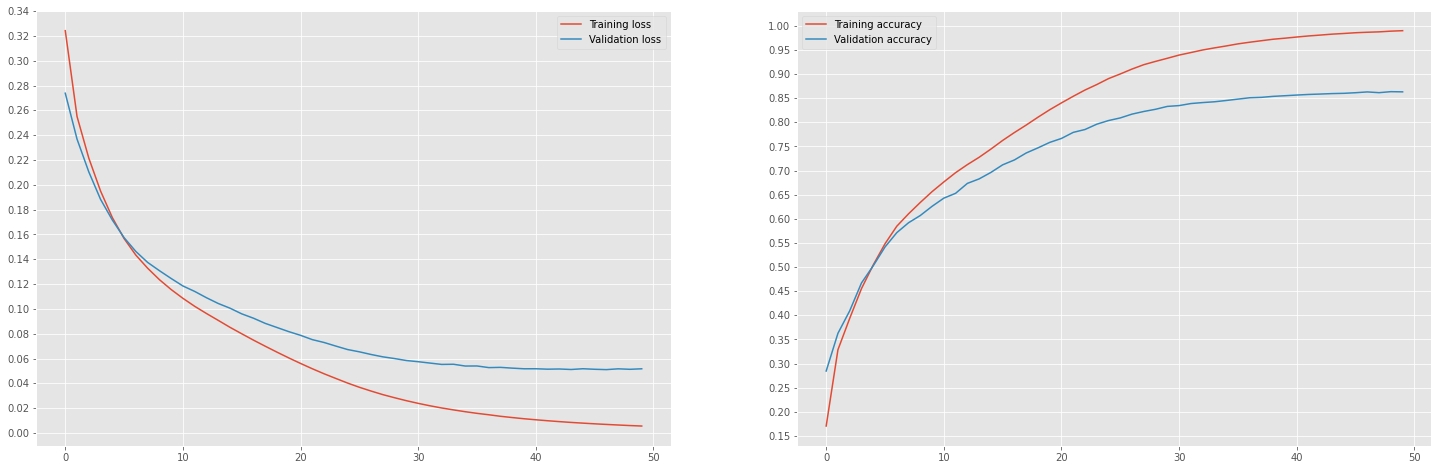

In [ ]:
#@title Plot loss and accuracy 
import matplotlib.pyplot as plt
plt.style.use("ggplot")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))
ax1.plot(gru_train_history.history["loss"], label="Training loss")
ax1.plot(gru_train_history.history["val_loss"], label="Validation loss")
ax1.locator_params(axis='y', nbins=20)
ax1.legend()

ax2.plot(gru_train_history.history["accuracy"], label="Training accuracy")
ax2.plot(gru_train_history.history["val_accuracy"], label="Validation accuracy")
ax2.locator_params(axis='y', nbins=25)
ax2.legend()

plt.show()

## Multi-layer LSTM model

Model with two bidirectional LSTM layers.

In [ ]:
#@title Model training {"display-mode": "form"}

def MultiLayerModel(params):
  lr = params['learning_rate'] if params['learning_rate'] else DEFAULT_LEARNING_RATE
  epochs = params['epochs'] if params['epochse'] else DEFAULT_EPOCHS

  double_model = [Bidirectional(GRU(MAX_SEQ_LENGTH, return_sequences=True)),
                  TimeDistributed(Dense(NUM_LABELS, activation="softmax"))]

  load_model = False #@param {type: "boolean"}
  if load_model and os.path.exists(os.path.join(OUTDIR, "double")):
    double_model = load_model(os.path.join(OUTDIR, "double"))
  else:
    double_model, double_train_history = build_model(
        "double", x_train, y_train, x_valid, y_valid, layers=baseline_layers,
        learning_rate=lr, #@param
        epochs=epochs, #@param
        min_improvement=DEFAULT_MIN_IMPROVEMENT, #@param,
        improvement_patience=DEFAULT_IMPROVEMENT_PATIENCE, #@param 
        debug=False, #@param {type: "boolean"}
        save=True, #@param {type: "boolean"}
    )

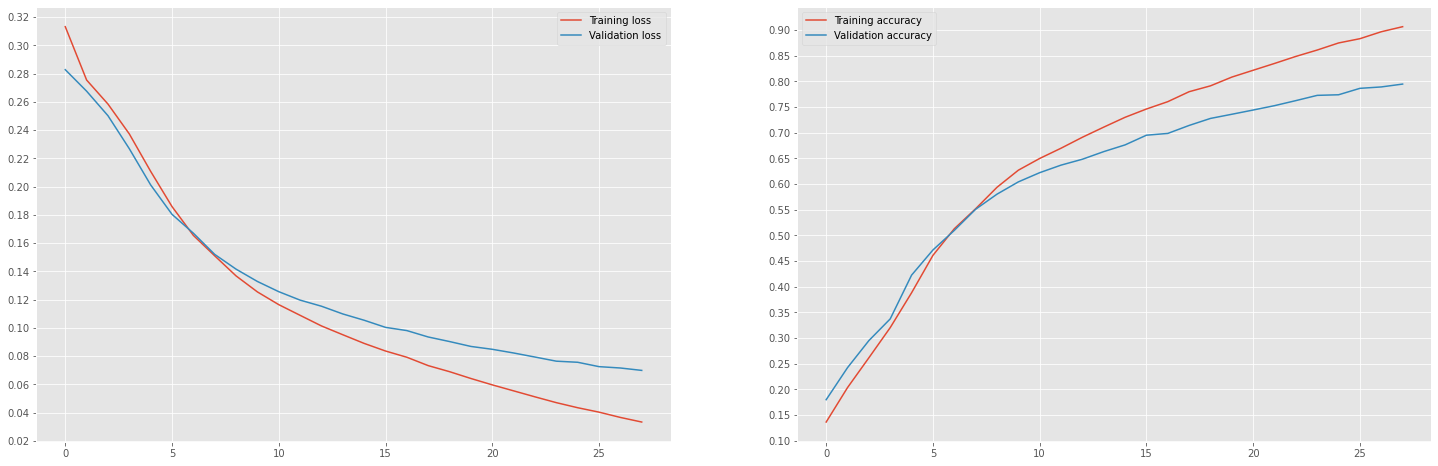

In [ ]:
#@title Plot loss and accuracy 
import matplotlib.pyplot as plt
plt.style.use("ggplot")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))
ax1.plot(double_train_history.history["loss"], label="Training loss")
ax1.plot(double_train_history.history["val_loss"], label="Validation loss")
ax1.locator_params(axis='y', nbins=20)
ax1.legend()

ax2.plot(double_train_history.history["accuracy"], label="Training accuracy")
ax2.plot(double_train_history.history["val_accuracy"], label="Validation accuracy")
ax2.locator_params(axis='y', nbins=20)
ax2.legend()

plt.show()

## Deeper model

Bidirectional LSTM network with two dense layers.

In [ ]:
#@title Model training {"display-mode": "form"}
def DeeperModel(params):
  lr = params['learning_rate'] if params['learning_rate'] else DEFAULT_LEARNING_RATE
  epochs = params['epochs'] if params['epochse'] else DEFAULT_EPOCHS

  deeper_model = [Bidirectional(GRU(MAX_SEQ_LENGTH, return_sequences=True)),
                  TimeDistributed(Dense(NUM_LABELS, activation="softmax"))]

  load_model = False #@param {type: "boolean"}
  if load_model and os.path.exists(os.path.join(OUTDIR, "deeper")):
    deeper_model = load_model(os.path.join(OUTDIR, "deeper"))
  else:
    deeper_model, deeper_train_history = build_model(
        "deeper", x_train, y_train, x_valid, y_valid, layers=baseline_layers,
        learning_rate=lr, #@param
        epochs=epochs, #@param
        min_improvement=DEFAULT_MIN_IMPROVEMENT, #@param,
        improvement_patience=DEFAULT_IMPROVEMENT_PATIENCE, #@param 
        debug=False, #@param {type: "boolean"}
        save=True, #@param {type: "boolean"}
    )

Cross Validation


In [ ]:
model_lbls = [
             'baseline', 
             'gru', 
              'multi', 
              'deeper', 
            ]

# Set the parameters to be explored by the grid for each classifier
tuned_param_baseline = [{'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4], "epochs": [32, 50, 100]}]
tuned_param_gru = [{'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4], "epochs": [32, 50, 100] }]
tuned_param_multi = [{'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4], "epochs": [32, 50, 100]}]
tuned_param_deeper = [{'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],"epochs": [32, 50, 100] }]


# set the models to be fitted specifying name, estimator and parameter structure
models = {
    'baseline': {
           'param': tuned_param_baseline
          },
    'gru': {
           'param': tuned_param_gru
            },
    'multi': {
           'param': tuned_param_multi
          },
    'deeper':{
           'param': tuned_param_deeper
          }
}



In [ ]:
from itertools

def CallModel(name, paramsprovided):

  indexList = []
  valuesList = []
  for param in paramsprovided.keys():
    indexList.append(param)
    valuesList.append(paramsprovided[param])


  #get all combinations of values to initialise:  
  paramsList = list(itertools.product(*valuesList))

  for list in valuesList:
    params = dict(zip(indexList, valuesList))

    if name == 'baseline':
      return BaselineModel(params)
    elif name == 'gru':
      return GruModel(params)
    elif name == 'multi':
      return MultiLayerModel(params)
    elif name == 'deeper':
      return DeeperModel(params)
    else return False


In [ ]:
def CrossValidation():
  for model in models_lbls:
    params = models[model]['param']
    for param in params:
    train_history, model = CallModel(model, params)
    


In [ ]:
# insert code here


final_scores = {}
best_scores = {}
for score in scores:
  for model in model_lbls:
    estimator = models[model]['name']
    params = models[model]['param']
    name = models[model]['name']
    clf = GridSearchCV(
        estimator, params, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full target set.")
    print()
    best_scores[name] = clf.best_score_
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
  
  final_scores[score] = best_scores





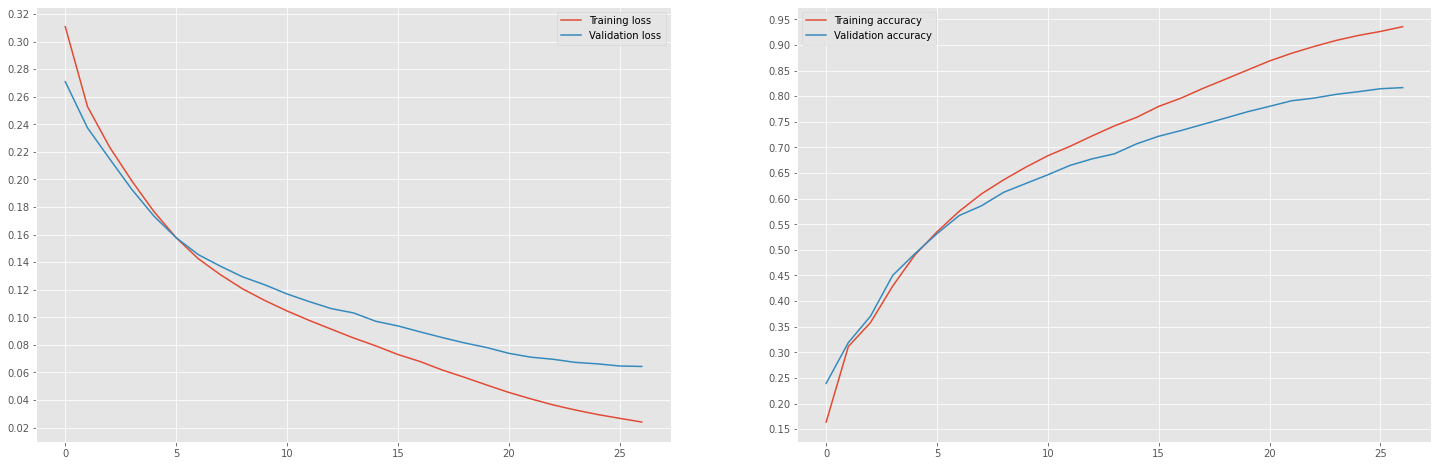

In [ ]:
#@title Plot loss and accuracy 
import matplotlib.pyplot as plt
plt.style.use("ggplot")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))
ax1.plot(denser_train_history.history["loss"], label="Training loss")
ax1.plot(denser_train_history.history["val_loss"], label="Validation loss")
ax1.locator_params(axis='y', nbins=20)
ax1.legend()

ax2.plot(denser_train_history.history["accuracy"], label="Training accuracy")
ax2.plot(denser_train_history.history["val_accuracy"], label="Validation accuracy")
ax2.locator_params(axis='y', nbins=25)
ax2.legend()

plt.show()

# Validation 

**here we should train on train and validation combined**

In [ ]:
def f1_metric(model, x, y):
  pred = model.predict(x)
  y_idx = np.argmax(y, axis=2).flatten()
  pred_idx = np.argmax(baseline_pred, axis=2).flatten()
  
  # remove punctuation indexes
  to_remove_idxs = np.isin(y_valid_idx, [0, 1, 2, 3, 4, 5, 44])
  
  y_idx = y_idx[~to_remove_idxs]
  pred_idx = pred_idx[~to_remove_idxs]
  f1 = f1_score(y_idx, pred_idx, average="macro")

  return f1

In [ ]:
print(f"Baseline F1-score: {f1_metric(baseline_model)}")
print(f"GRU F1-score: {f1_metric(gru_model)}")
print(f"Double LSTM F1-score: {f1_metric(double_model)}")
print(f"Deeper LSTM F1-score: {f1_metric(deeper_model)}")

0.6484761229863087